In [1]:
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import json, ast, sys, csv, random
import plotly.express as px
import math
import datetime
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt


#Implement training process
from model_trees_algebra import NeoRegression

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from functions.tree_format import IterateBuildTree, InnerJoinsIntraBGPS, \
                                IterateBuildTreeBetweenBGPS, TreeFormat
from functions.RL_functions import GetTriplesSubtree, \
                                        GetTreeSize, \
                                        GetAllJoins, \
                                        GetIter, \
                                        GetTotalBgp, \
                                        GetDataframe

from functions.aux import MetricTotalAccuraccy


class BaoTrainingException(Exception):
    pass
csv.field_size_limit(sys.maxsize)
URL = "/media/data/ccarmona/memoria/dataset/rl_csvs/"

IS CUDA AVAILABLE: True


In [2]:
model_name = 'Model_Adam_0.00015'

In [3]:
#ds_rl = pd.read_csv(URL + "ds_rl.csv", engine='python', encoding='utf-8')
n = model_name
#neo_df = pd.read_csv(URL + "neo_df.csv", engine='python', encoding='utf-8')
neo_df_no_history = pd.read_csv(URL + "neo_df_no_history" + str(n) +".csv", engine='python', encoding='utf-8')
neo_df_final = pd.read_csv(URL + "neo_df_final"+ str(n) +".csv", engine='python', encoding='utf-8')

#ql_df = pd.read_csv(URL + "ql_df.csv", engine='python', encoding='utf-8')
ql_df_no_history = pd.read_csv(URL + "ql_df_no_history"+ str(n) +".csv", engine='python', encoding='utf-8')
ql_df_final = pd.read_csv(URL + "ql_df_final"+ str(n) +".csv", engine='python', encoding='utf-8')

#sarsa_df = pd.read_csv(URL + "sarsa_df.csv", engine='python', encoding='utf-8')
sarsa_df_no_history = pd.read_csv(URL + "sarsa_df_no_history"+ str(n) +".csv", engine='python', encoding='utf-8')
sarsa_df_final = pd.read_csv(URL + "sarsa_df_final"+ str(n) +".csv", engine='python', encoding='utf-8')

#exsarsa_df = pd.read_csv(URL + "exsarsa_df.csv", engine='python', encoding='utf-8')
exsarsa_df_no_history = pd.read_csv(URL + "exsarsa_df_no_history"+ str(n) +".csv", engine='python', encoding='utf-8')
exsarsa_df_final = pd.read_csv(URL + "exsarsa_df_final"+ str(n) +".csv", engine='python', encoding='utf-8')

In [4]:
neo_df_final

,index,iteration,pred_old,pred_new,real_old,real_new,mse_old,mse_new,mae_old,mae_new,rmse_old,rmse_new,old_tree,new_tree
0,0,199,64.135323,58.311447,50.0,50.0,199.807344,69.080154,14.135323,8.311447,14.135323,8.311447,"['[""JOINᶲIRI_ID;...direct/P2053;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2053;"", [""VAR_VAR_V..."
1,1,199,79.218193,55.413563,50.0,50.0,853.702805,29.306662,29.218193,5.413563,29.218193,5.413563,"['[""JOINᶲIRI_ID;...direct/P9325;ᶲIRI_ID;...dir...","['[""JOINᶲIRI_ID;...direct/P2579;ᶲIRI_ID;...dir..."
2,2,199,68.613136,69.700851,50.0,50.0,346.448843,388.123547,18.613136,19.700851,18.613136,19.700851,"['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']"
3,3,199,70.569603,70.568542,50.0,50.0,423.108566,423.064940,20.569603,20.568542,20.569603,20.568542,"['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire..."
4,4,199,70.618965,69.960991,50.0,50.0,425.141724,398.441158,20.618965,19.960991,20.618965,19.960991,"['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,1472,199,88.507919,79.413895,139.0,139.0,2549.450212,3550.503950,50.492081,59.586105,50.492081,59.586105,"['[""JOINᶲIRI_ID;...direct/P4145;ᶲIRI_ID;...dir...","['[""JOINᶲIRI_ID;...direct/P8897;ᶲIRI_ID;...dir..."
1473,1473,199,36.480751,36.520672,103.0,103.0,4424.810483,4419.501072,66.519249,66.479328,66.519249,66.479328,"['[""VAR_URI_VARᶲIRI_ID;...direct/P2639;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P2639;""]']"
1474,1474,199,139.420181,55.016308,123.0,123.0,269.622353,4621.782401,16.420181,67.983692,16.420181,67.983692,"['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_VAR_V..."
1475,1475,199,126.116714,59.420265,114.0,114.0,146.814770,2978.947451,12.116714,54.579735,12.116714,54.579735,"['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_VAR_V..."


In [5]:
ql_df_final

,index,iteration,pred_old,pred_new,real_old,real_new,mse_old,mse_new,mae_old,mae_new,rmse_old,rmse_new,old_tree,new_tree
0,0,199,63.567566,64.970650,50.0,50.0,184.078845,224.120353,13.567566,14.970650,13.567566,14.970650,"['[""JOINᶲIRI_ID;...direct/P2053;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2053;"", [""VAR_URI_V..."
1,1,199,84.341347,81.188560,50.0,50.0,1179.328096,972.726305,34.341347,31.188560,34.341347,31.188560,"['[""JOINᶲIRI_ID;...direct/P9325;ᶲIRI_ID;...dir...","['[""JOINᶲIRI_ID;...direct/P9325;ᶲIRI_ID;...dir..."
2,2,199,68.056450,68.442062,50.0,50.0,326.035383,340.109665,18.056450,18.442062,18.056450,18.442062,"['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']"
3,3,199,70.051933,70.475845,50.0,50.0,402.080029,419.260242,20.051933,20.475845,20.051933,20.475845,"['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire..."
4,4,199,70.024796,70.355743,50.0,50.0,400.992436,414.356290,20.024796,20.355743,20.024796,20.355743,"['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,1472,199,89.010605,96.991745,139.0,139.0,2498.939627,1764.693489,49.989395,42.008255,49.989395,42.008255,"['[""JOINᶲIRI_ID;...direct/P4145;ᶲIRI_ID;...dir...","['[""JOINᶲIRI_ID;...direct/P4145;ᶲIRI_ID;...dir..."
1473,1473,199,36.802933,42.542542,103.0,103.0,4382.051714,3655.104288,66.197067,60.457458,66.197067,60.457458,"['[""VAR_URI_VARᶲIRI_ID;...direct/P2639;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P2639;""]']"
1474,1474,199,139.356186,55.053741,123.0,123.0,267.524818,4616.694050,16.356186,67.946259,16.356186,67.946259,"['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_VAR_V..."
1475,1475,199,125.639488,59.224239,114.0,114.0,135.477686,3000.383955,11.639488,54.775761,11.639488,54.775761,"['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_VAR_V..."


In [6]:
sarsa_df_final

,index,iteration,pred_old,pred_new,real_old,real_new,mse_old,mse_new,mae_old,mae_new,rmse_old,rmse_new,old_tree,new_tree
0,0,199,65.295044,64.744766,50.0,50.0,233.938369,217.408131,15.295044,14.744766,15.295044,14.744766,"['[""JOINᶲIRI_ID;...direct/P2053;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2053;"", [""VAR_URI_V..."
1,1,199,82.515175,79.579483,50.0,50.0,1057.236597,874.945816,32.515175,29.579483,32.515175,29.579483,"['[""JOINᶲIRI_ID;...direct/P9325;ᶲIRI_ID;...dir...","['[""JOINᶲIRI_ID;...direct/P9325;ᶲIRI_ID;...dir..."
2,2,199,68.110542,68.444649,50.0,50.0,327.991742,340.205067,18.110542,18.444649,18.110542,18.444649,"['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']"
3,3,199,70.420448,70.280548,50.0,50.0,416.994709,411.300631,20.420448,20.280548,20.420448,20.280548,"['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire..."
4,4,199,70.381332,70.233627,50.0,50.0,415.398710,409.399674,20.381332,20.233627,20.381332,20.233627,"['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,1472,199,86.146683,93.977760,139.0,139.0,2793.473145,2027.002066,52.853317,45.022240,52.853317,45.022240,"['[""JOINᶲIRI_ID;...direct/P4145;ᶲIRI_ID;...dir...","['[""JOINᶲIRI_ID;...direct/P4145;ᶲIRI_ID;...dir..."
1473,1473,199,37.005219,38.363113,103.0,103.0,4355.311184,4177.927109,65.994781,64.636887,65.994781,64.636887,"['[""VAR_URI_VARᶲIRI_ID;...direct/P2639;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P2639;""]']"
1474,1474,199,139.589020,55.645863,123.0,123.0,275.195577,4536.579828,16.589020,67.354137,16.589020,67.354137,"['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_VAR_V..."
1475,1475,199,125.607361,59.187809,114.0,114.0,134.730826,3004.376283,11.607361,54.812191,11.607361,54.812191,"['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_VAR_V..."


In [7]:
exsarsa_df_final

,index,iteration,pred_old,pred_new,real_old,real_new,mse_old,mse_new,mae_old,mae_new,rmse_old,rmse_new,old_tree,new_tree
0,0,199,63.491074,63.490486,50.0,50.0,182.009067,181.993216,13.491074,13.490486,13.491074,13.490486,"['[""JOINᶲIRI_ID;...direct/P2053;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2053;"", [""VAR_URI_V..."
1,1,199,79.649101,83.341301,50.0,50.0,879.069205,1111.642350,29.649101,33.341301,29.649101,33.341301,"['[""JOINᶲIRI_ID;...direct/P9325;ᶲIRI_ID;...dir...","['[""JOINᶲIRI_ID;...direct/P2579;ᶲIRI_ID;...dir..."
2,2,199,70.073074,68.111000,50.0,50.0,402.928313,328.008323,20.073074,18.111000,20.073074,18.111000,"['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P570;""]']"
3,3,199,70.154053,69.807060,50.0,50.0,406.185842,392.319635,20.154053,19.807060,20.154053,19.807060,"['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire..."
4,4,199,70.701996,70.585846,50.0,50.0,428.572632,423.777053,20.701996,20.585846,20.701996,20.585846,"['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire...","['[""JOINᶲIRI_ID;...direct/P279;ᶲIRI_ID;...dire..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,1472,199,87.223862,95.848068,139.0,139.0,2680.768498,1862.089215,51.776138,43.151932,51.776138,43.151932,"['[""JOINᶲIRI_ID;...direct/P4145;ᶲIRI_ID;...dir...","['[""JOINᶲIRI_ID;...direct/P8591;ᶲIRI_ID;...dir..."
1473,1473,199,36.480751,36.480751,103.0,103.0,4424.810483,4424.810483,66.519249,66.519249,66.519249,66.519249,"['[""VAR_URI_VARᶲIRI_ID;...direct/P2639;""]']","['[""VAR_URI_VARᶲIRI_ID;...direct/P2639;""]']"
1474,1474,199,139.152405,56.031563,123.0,123.0,260.900180,4484.771580,16.152405,66.968437,16.152405,66.968437,"['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P2386;"", [""VAR_VAR_V..."
1475,1475,199,126.608086,59.423954,114.0,114.0,158.963823,2978.544796,12.608086,54.576046,12.608086,54.576046,"['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_URI_V...","['[""JOINᶲIRI_ID;...direct/P1725;"", [""VAR_VAR_V..."


### Latencia promedio de cada algoritmo + promedio real

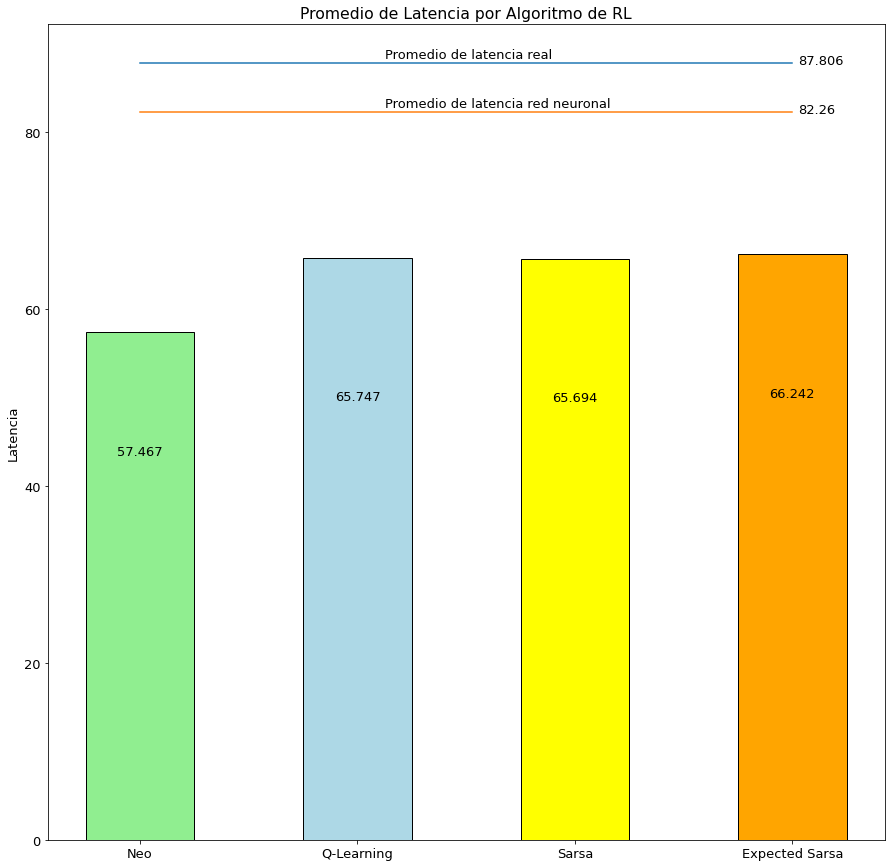

In [8]:
"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
ind = np.arange(4)*0.4
real_value = [np.mean(ql_df_final['real_new']) for i in range(4)]
old_pred = [np.mean(ql_df_final['pred_old']) for i in range(4)]
h = [
    np.mean(neo_df_final['pred_new']),
    np.mean(ql_df_final['pred_new']),
    np.mean(sarsa_df_final['pred_new']),
    np.mean(exsarsa_df_final['pred_new']),
]
c = ['lightgreen','lightblue','yellow','orange']
names = ('Neo','Q-Learning','Sarsa','Expected Sarsa')

width = 0.2      # the width of the bars

fig, ax = plt.subplots(figsize=(15,15))
rects = ax.bar(ind, h, width, color=c, edgecolor = 'black')
line1 = ax.plot(ind, real_value);
line2 = ax.plot(ind, old_pred);

# add some text for labels, title and axes ticks
ax.set_ylabel('Latencia')
ax.set_title('Promedio de Latencia por Algoritmo de RL')
ax.set_xticks(ind)
ax.set_xticklabels(names)


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.75*height,
                str(round(float(height),3)),
                ha='center', va='bottom')

ax.text(ind[1]+0.05,real_value[0] + 0.55,'Promedio de latencia real')
ax.text(ind[1]+0.05,old_pred[0] + 0.55,'Promedio de latencia red neuronal')
ax.text(ind[3]+0.01,real_value[0] - 0.1,str(round(real_value[0],3)))
ax.text(ind[3]+0.01,old_pred[0] - 0.1,str(round(old_pred[0],2)))
autolabel(rects)


plt.show()

### Latencia promedio por iteración de  cada consulta para cada algoritmo + promedio real

In [9]:
def PromedioPorIteracionFormato(df, num_iter):
    aux_dict = {}
    values_pred = []
    for i in range(num_iter):
        aux_dict[str(i)] = {"index" : 0, "preds" : [], "mean_preds" : []}
    for i in range(len(df)):
        a = [df['index'][i],df['iteration'][i],df['pred_new'][i]]
        aux_dict[str(a[1])]["index"] = a[0]
        aux_dict[str(a[1])]["preds"].append(float(a[2]))
    for k,v in aux_dict.items():
        aux_dict[k]["mean_preds"] = np.mean(aux_dict[k]["preds"])
        values_pred.append(np.mean(aux_dict[k]["preds"]))
    index_list = [int(x) for x in list(aux_dict.keys())]
    return index_list, values_pred
def PromedioPorIteracion(df):
    index_list, values_pred = PromedioPorIteracionFormato(df)
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(index_list, values_pred);

In [10]:
index_list_ql, values_pred_ql = PromedioPorIteracionFormato(ql_df_no_history,200)
index_list_neo, values_pred_neo = PromedioPorIteracionFormato(neo_df_no_history,200)
index_list_sarsa, values_pred_sarsa = PromedioPorIteracionFormato(sarsa_df_no_history,200)
index_list_exsarsa, values_pred_exsarsa = PromedioPorIteracionFormato(exsarsa_df_no_history,200)

In [11]:
real_value = np.ones(len(index_list_ql))*np.mean(ql_df_final['real_new'])
old_predict = np.ones(len(index_list_ql))*np.mean(ql_df_final['pred_old'])

In [12]:
np.mean(ql_df_final['pred_old'])

82.2643489718195

[Text(0.5, 0, 'Iteraciones'), Text(0, 0.5, 'Latencia promedio')]

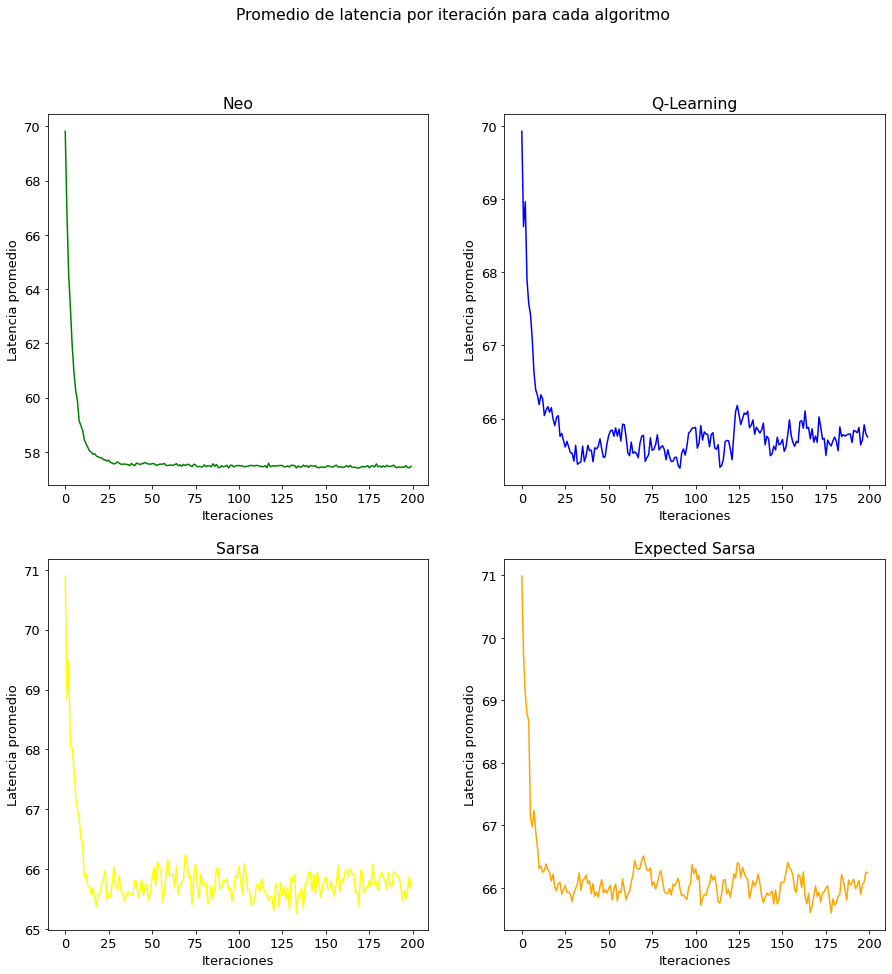

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Promedio de latencia por iteración para cada algoritmo')
c = ['green','blue','yellow','orange','grey','black']
ax1.set_title('Neo')
ax1.plot(index_list_neo, values_pred_neo, color=c[0])
#ax1.plot(index_list_neo, real_value, color=c[5], linestyle='dashed')
#ax1.plot(index_list_neo, old_predict, color=c[4], linestyle='dashed')

ax2.set_title('Q-Learning')
ax2.plot(index_list_ql, values_pred_ql, color=c[1])
#ax2.plot(index_list_ql, real_value, color=c[5], linestyle='dashed')
#ax2.plot(index_list_ql, old_predict, color=c[4], linestyle='dashed')

ax3.set_title('Sarsa')
ax3.plot(index_list_sarsa, values_pred_sarsa, color=c[2])
#ax3.plot(index_list_sarsa, real_value, color=c[5], linestyle='dashed')
#ax3.plot(index_list_sarsa, old_predict, color=c[4], linestyle='dashed')

ax4.set_title('Expected Sarsa')
ax4.plot(index_list_exsarsa, values_pred_exsarsa, color=c[3])
#ax4.plot(index_list_exsarsa, real_value, color=c[5], linestyle='dashed')
#ax4.plot(index_list_exsarsa, old_predict, color=c[4], linestyle='dashed')
#for ax in fig.get_axes():
#ax.label_outer()

# set labels
plt.setp(ax1, xlabel='Iteraciones', ylabel='Latencia promedio')
plt.setp(ax2, xlabel='Iteraciones', ylabel='Latencia promedio')
plt.setp(ax3, xlabel='Iteraciones', ylabel='Latencia promedio')
plt.setp(ax4, xlabel='Iteraciones', ylabel='Latencia promedio')


### Consultas mejoradas, consultas iguales, consultas empeoradas

In [14]:
def tag_points(x):
    """Add quality tags of predictions. Used to plot with plotly"""
    difference = x['time'] - x['y_pred'][0]
    abs_diff = np.abs(difference)
    x['y_pred'] = x['y_pred'][0]
    x['query2'] = x['query'].replace(" . ", ' . <br>').replace(" FILTER", '<br> FILTER').replace(" { ", ' { <br>').replace(" } ", ' <br> }').replace(" ; ", ' ; <br>') 
    p20 = x['time'] * 0.2
    p40 = x['time'] * 0.4
    if abs_diff < p20:
        x['color'] = "good prediction"
    elif abs_diff < p40:
        x['color'] = "aceptable prediction"
    else:
        x['color'] = "bad prediction"
    return x

In [15]:
def tag_best_worst_equal(x, tol):
    difference = x['pred_old'] - x['pred_new']
    if difference < -tol:
        x['tag'] = "peor"
    elif difference >= -tol and difference <= tol:
        x['tag'] = "igual"
    else:
        x['tag'] = "mejor"
    
    return x

In [16]:
neo_df_final = neo_df_final.apply(lambda x: tag_best_worst_equal(x,0), axis=1)
ql_df_final = ql_df_final.apply(lambda x: tag_best_worst_equal(x,0), axis=1)
sarsa_df_final = sarsa_df_final.apply(lambda x: tag_best_worst_equal(x,0), axis=1)
exsarsa_df_final = exsarsa_df_final.apply(lambda x: tag_best_worst_equal(x,0), axis=1)

In [17]:
#for i in range(len(ql_df_final)):
#    print(neo_df_final['pred_old'][i],neo_df_final['pred_new'][i],neo_df_final['tag'][i])

In [18]:
neo_igual = int(neo_df_final.groupby('tag').count()['index']['igual'])
neo_mejor = int(neo_df_final.groupby('tag').count()['index']['mejor'])
neo_peor = int(neo_df_final.groupby('tag').count()['index']['peor'])

ql_igual = int(ql_df_final.groupby('tag').count()['index']['igual'])
ql_mejor = int(ql_df_final.groupby('tag').count()['index']['mejor'])
ql_peor = int(ql_df_final.groupby('tag').count()['index']['peor'])

sarsa_igual = int(sarsa_df_final.groupby('tag').count()['index']['igual'])
sarsa_mejor = int(sarsa_df_final.groupby('tag').count()['index']['mejor'])
sarsa_peor = int(sarsa_df_final.groupby('tag').count()['index']['peor'])

exsarsa_igual = int(exsarsa_df_final.groupby('tag').count()['index']['igual'])
exsarsa_mejor = int(exsarsa_df_final.groupby('tag').count()['index']['mejor'])
exsarsa_peor = int(exsarsa_df_final.groupby('tag').count()['index']['peor'])

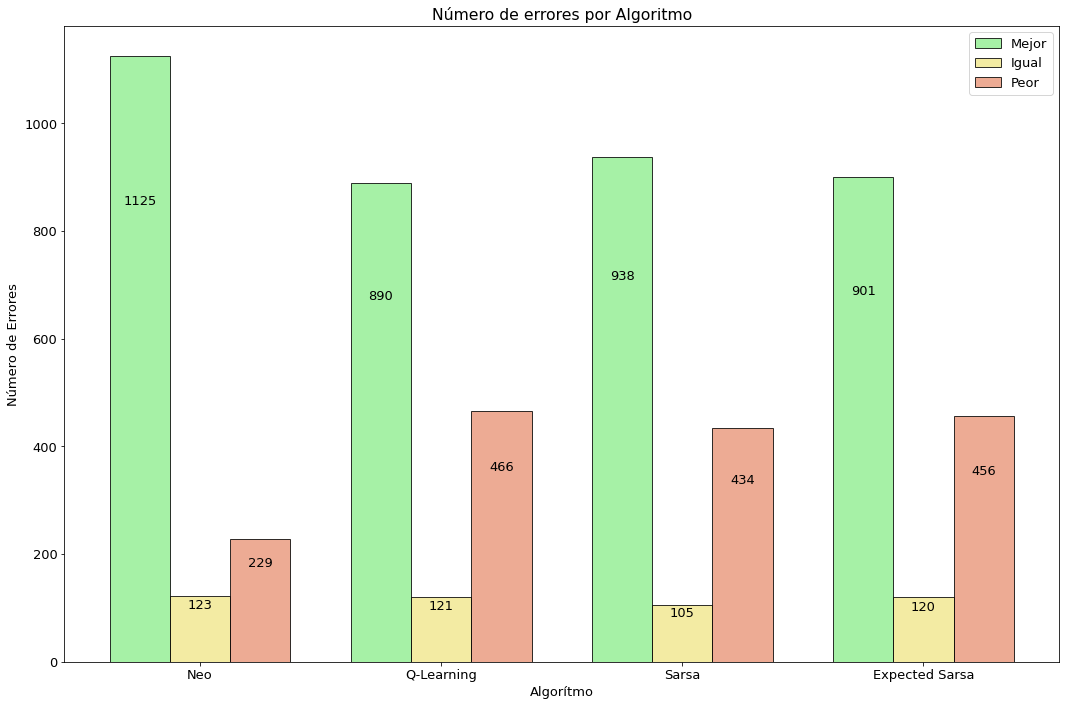

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
# data to plot
n_groups = 4
igual = (neo_igual, ql_igual, sarsa_igual, exsarsa_igual)
mejor = (neo_mejor, ql_mejor, sarsa_mejor, exsarsa_mejor)
peor = (neo_peor, ql_peor, sarsa_peor, exsarsa_peor)

# create plot
fig, ax = plt.subplots(figsize=(15,10))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, mejor, bar_width,
alpha=opacity,
color='lightgreen',
label='Mejor',
edgecolor = 'black')

rects2 = plt.bar(index + bar_width, igual, bar_width,
alpha=opacity,
color='khaki',
label='Igual',
edgecolor = 'black')

rects3 = plt.bar(index + 2*bar_width, peor, bar_width,
alpha=opacity,
color='darksalmon',
label='Peor',
edgecolor = 'black')

plt.xlabel('Algorítmo')
plt.ylabel('Número de Errores')
plt.title('Número de errores por Algoritmo')
plt.xticks(index + bar_width, ('Neo', 'Q-Learning', 'Sarsa', 'Expected Sarsa'))
plt.legend()
plt.tight_layout()


for i in index:
    ax.text(index[i], 
             mejor[i]*0.75,
             str(mejor[i]),
             ha='center', va='bottom',
            )
    ax.text(index[i] + bar_width, 
             igual[i]*0.75,
             str(igual[i]),
             ha='center', va='bottom',
            )
    ax.text(index[i] + 2*bar_width, 
             peor[i]*0.75,
             str(peor[i]),
             ha='center', va='bottom',
            )


plt.show()

##### Por tipo rango de latencia

In [20]:
def split_by_latency(df_final):
    df = df_final.copy()
    #df_0_10 = df[df['pred_new'] < 10]
    #df_10_20 = df[(df['pred_new'] >= 10) & (df['pred_new'] < 20)]
    #df_20_30 = df[(df['pred_new'] >= 20) & (df['pred_new'] < 30)]
    #df_30_40 = df[(df['pred_new'] >= 30) & (df['pred_new'] < 40)]
    #df_40_50 = df[(df['pred_new'] >= 40) & (df['pred_new'] < 50)]
    #df_50_60 = df[(df['pred_new'] >= 50) & (df['pred_new'] < 60)]
    #df_60 = df[df['pred_new'] >= 60]
    df_0_20 = df[df['real_old'] < 20]
    df_20_30 = df[(df['real_old'] >= 20) & (df['real_old'] < 30)]
    df_30_40 = df[(df['real_old'] >= 30) & (df['real_old'] < 40)]
    df_40_50 = df[(df['real_old'] >= 40) & (df['real_old'] < 50)]
    df_50_60 = df[(df['real_old'] >= 50) & (df['real_old'] < 60)]
    df_60 = df[df['real_old'] >= 60]
    #return df_0_10, df_10_20 ,df_20_30, df_30_40, df_40_50, df_50_60, df_60
    return df_0_20,df_20_30,df_30_40,df_40_50,df_50_60,df_60

def count_igual_mejor_peor(df):
    try:
        igual = int(df.groupby('tag').count()['index']['igual'])
    except:
        igual = 0
    try:
        mejor = int(df.groupby('tag').count()['index']['mejor'])
    except:
        mejor = 0
    try:
        peor = int(df.groupby('tag').count()['index']['peor'])
    except:
        peor = 0
    return igual,mejor,peor

In [21]:
def plot_errores_rango(df_final,nombre_algoritmo):
    igual = []
    mejor = []
    peor = []
    for df in split_by_latency(df_final):
        i, m, p = count_igual_mejor_peor(df)
        igual.append(i)
        mejor.append(m)
        peor.append(p)
    plt.rcParams.update({'font.size': 13})
    # data to plot
    n_groups = len(igual)
    #igual = (neo_igual, ql_igual, sarsa_igual, exsarsa_igual)
    #mejor = (neo_mejor, ql_mejor, sarsa_mejor, exsarsa_mejor)
    #peor = (neo_peor, ql_peor, sarsa_peor, exsarsa_peor)

    # create plot
    fig, ax = plt.subplots(figsize=(15,10))
    index = np.arange(n_groups)
    bar_width = 0.15
    opacity = 0.8

    rects1 = plt.bar(index, mejor, bar_width,
    alpha=opacity,
    color='lightgreen',
    label='Mejor',
    edgecolor = 'black')

    rects2 = plt.bar(index + bar_width, igual, bar_width,
    alpha=opacity,
    color='khaki',
    label='Igual',
    edgecolor = 'black')

    rects3 = plt.bar(index + 2*bar_width, peor, bar_width,
    alpha=opacity,
    color='darksalmon',
    label='Peor',
    edgecolor = 'black')

    plt.xlabel('Rango de latencia')
    plt.ylabel('Número de Errores')
    plt.title(f'Número de errores {nombre_algoritmo} por rangos de latencia')
    plt.xticks(index + bar_width, ('[0-20)','[20-30)','[30-40)','[40-50)','[50-60)','60+'))
    plt.legend()
    plt.tight_layout()


    for i in index:
        ax.text(index[i], 
                 mejor[i]*0.75,
                 str(mejor[i]),
                 ha='center', va='bottom',
                )
        ax.text(index[i] + bar_width, 
                 igual[i]*0.75,
                 str(igual[i]),
                 ha='center', va='bottom',
                )
        ax.text(index[i] + 2*bar_width, 
                 peor[i]*0.75,
                 str(peor[i]),
                 ha='center', va='bottom',
                )
    plt.show()

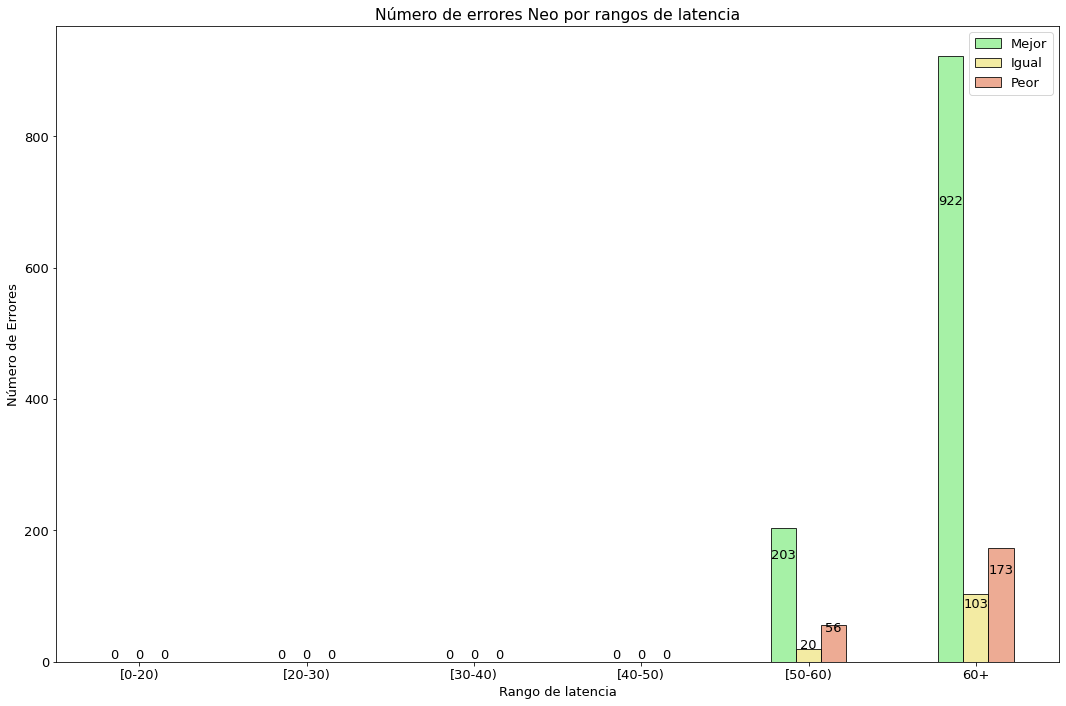

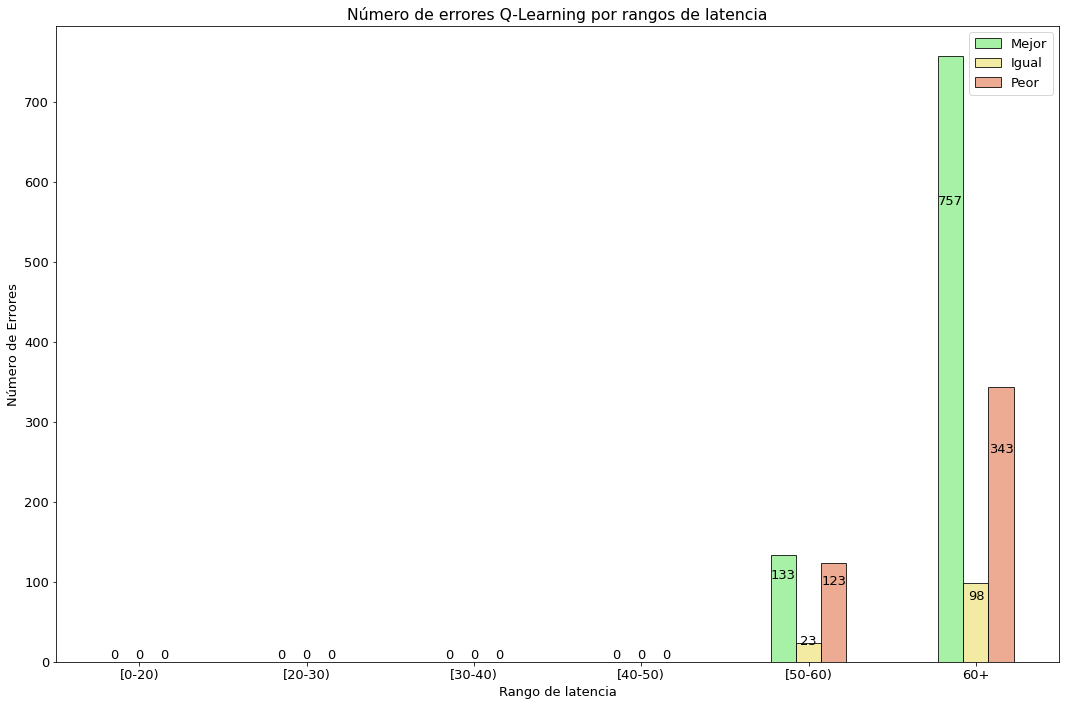

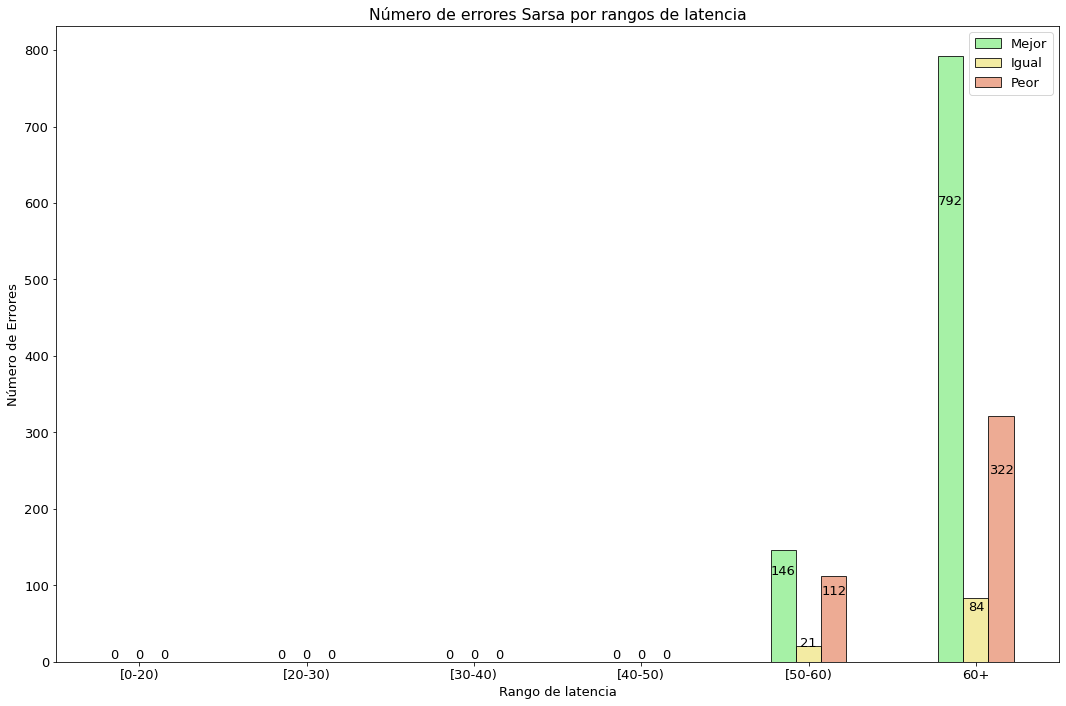

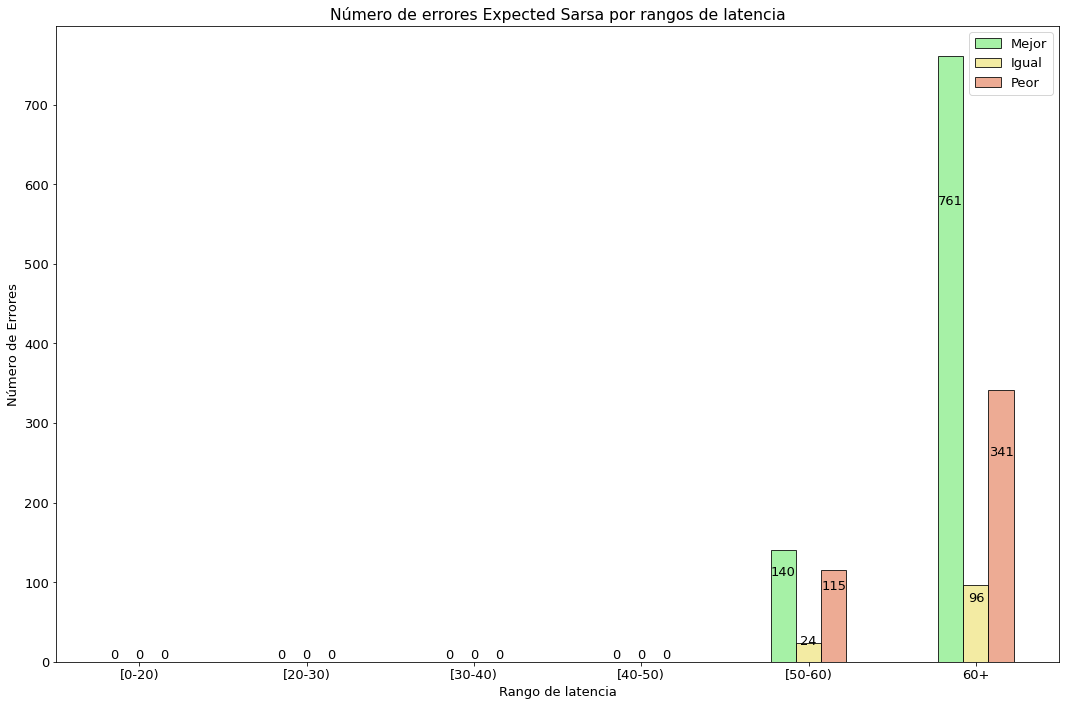

In [22]:
plot_errores_rango(neo_df_final,'Neo')
plot_errores_rango(ql_df_final,'Q-Learning')
plot_errores_rango(sarsa_df_final,'Sarsa')
plot_errores_rango(exsarsa_df_final,'Expected Sarsa')

### Latencia promedio de cada consulta diferenciado por numero de JOINs para cada algoritmo

In [23]:
def split_by_joins(df, val):
    joins_1_p, joins_1_e =[],[]
    joins_2_p, joins_2_e =[],[]
    joins_3_p, joins_3_e =[],[]
    joins_4_p, joins_4_e =[],[]
    joins_5_p, joins_5_e =[],[]
    joins_6_p, joins_6_e =[],[]
    #<
    #>
    columns = 'tag'
    for i in range(len(df)):
        count_joins = df['new_tree'][i].count('JOIN') 
        if count_joins == 1:
            joins_1_p.append(df[val][i])
            joins_1_e.append(df['tag'][i])
        elif count_joins == 2:
            joins_2_p.append(df[val][i])
            joins_2_e.append(df['tag'][i])       
        elif count_joins == 3:
            joins_3_p.append(df[val][i])
            joins_3_e.append(df['tag'][i])       
        elif count_joins == 4:
            joins_4_p.append(df[val][i])
            joins_4_e.append(df['tag'][i])       
        elif count_joins == 5:
            joins_5_p.append(df[val][i])
            joins_5_e.append(df['tag'][i])       
        else:
            joins_6_p.append(df[val][i])
            joins_6_e.append(df['tag'][i])       
    promedio = [joins_1_p, joins_2_p, joins_3_p, joins_4_p, joins_5_p, joins_6_p]
    errores = [joins_1_e, joins_2_e, joins_3_e, joins_4_e, joins_5_e, joins_6_e]
    return promedio, errores 


In [24]:
original_p_joins, original_e_joins = split_by_joins(neo_df_final, 'real_old')
neo_p_joins, neo_e_joins = split_by_joins(neo_df_final,'pred_new')
ql_p_joins, ql_e_joins = split_by_joins(ql_df_final, 'pred_new')
sarsa_p_joins, sarsa_e_joins = split_by_joins(sarsa_df_final, 'pred_new')
exsarsa_p_joins, exsarsa_e_joins = split_by_joins(exsarsa_df_final, 'pred_new')

In [25]:
len(exsarsa_p_joins[0])

785

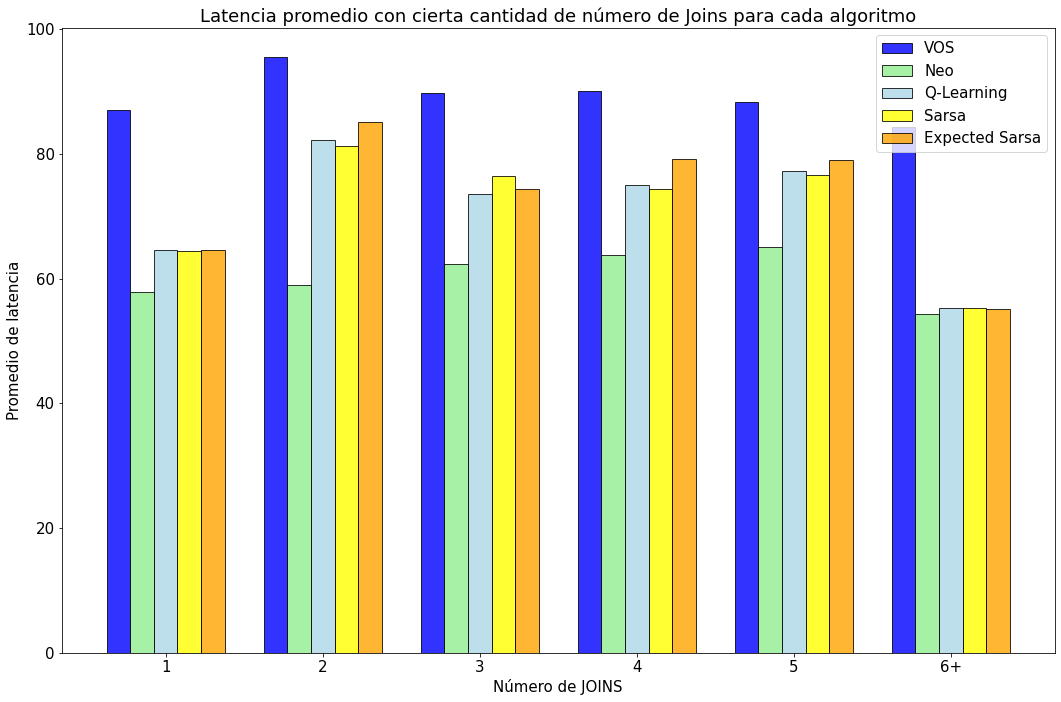

In [26]:

plt.rcParams.update({'font.size': 15})
# data to plot
n_groups = len(neo_p_joins)
    #igual = (neo_igual, ql_igual, sarsa_igual, exsarsa_igual)
    #mejor = (neo_mejor, ql_mejor, sarsa_mejor, exsarsa_mejor)
    #peor = (neo_peor, ql_peor, sarsa_peor, exsarsa_peor)

 # create plot
fig, ax = plt.subplots(figsize=(15,10))
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
c = ['blue','lightgreen','lightblue','yellow','orange']


mean_original = np.array([np.mean(val) for val in original_p_joins])
mean_neo = np.array([np.mean(val) for val in neo_p_joins])
mean_ql = np.array([np.mean(val) for val in ql_p_joins])
mean_sarsa = np.array([np.mean(val) for val in sarsa_p_joins])
mean_exsarsa = np.array([np.mean(val) for val in exsarsa_p_joins])


rects_original = plt.bar(index, mean_original, bar_width,
alpha=opacity,
color=c[0],
edgecolor = 'black',
label='VOS')
rects_neo = plt.bar(index+bar_width, mean_neo, bar_width,
alpha=opacity,
color=c[1],
edgecolor = 'black',
label='Neo')
rects_ql = plt.bar(index+bar_width*2, mean_ql, bar_width,
alpha=opacity,
color=c[2],
edgecolor = 'black',
label='Q-Learning')
rects_sarsa = plt.bar(index+bar_width*3, mean_sarsa, bar_width,
alpha=opacity,
color=c[3],
edgecolor = 'black',
label='Sarsa')
rects_exsarsa = plt.bar(index+bar_width*4, mean_exsarsa, bar_width,
alpha=opacity,
color=c[4],
edgecolor = 'black',
label='Expected Sarsa')


plt.xlabel('Número de JOINS')
plt.ylabel('Promedio de latencia')
plt.title(f'Latencia promedio con cierta cantidad de número de Joins para cada algoritmo')
plt.xticks(index+bar_width*2, ('1','2','3','4','5','6+'))
plt.legend()
plt.tight_layout()




plt.show()

### Consultas mejoradas, consultas iguales, consultas empeoradas diferenciados por numero de JOINs

In [27]:
def plot_errores_join(lista_e_join,nombre_algoritmo):
    igual = []
    mejor = []
    peor = []
    for j in lista_e_join:
        i, m, p = j.count('igual'), j.count('mejor'), j.count('peor')
        igual.append(i)
        mejor.append(m)
        peor.append(p)
    plt.rcParams.update({'font.size': 13})
    # data to plot
    n_groups = len(igual)
    #igual = (neo_igual, ql_igual, sarsa_igual, exsarsa_igual)
    #mejor = (neo_mejor, ql_mejor, sarsa_mejor, exsarsa_mejor)
    #peor = (neo_peor, ql_peor, sarsa_peor, exsarsa_peor)

    # create plot
    fig, ax = plt.subplots(figsize=(15,10))
    index = np.arange(n_groups)
    bar_width = 0.15
    opacity = 0.8

    rects1 = plt.bar(index, mejor, bar_width,
    alpha=opacity,
    color='lightgreen',
    label='Mejor',
    edgecolor = 'black')

    rects2 = plt.bar(index + bar_width, igual, bar_width,
    alpha=opacity,
    color='khaki',
    label='Igual',
    edgecolor = 'black')

    rects3 = plt.bar(index + 2*bar_width, peor, bar_width,
    alpha=opacity,
    color='darksalmon',
    label='Peor',
    edgecolor = 'black')

    plt.xlabel('Número de JOINS')
    plt.ylabel('Promedio de latencia')
    plt.title(f'Número de errores por número de JOINS para algoritmo {nombre_algoritmo}')
    plt.xticks(index + bar_width, ('1','2','3','4','5','6+'))
    plt.legend()
    plt.tight_layout()


    for i in index:
        ax.text(index[i], 
                 mejor[i]*0.7,
                 str(mejor[i]),
                 ha='center', va='bottom',
                )
        ax.text(index[i] + bar_width, 
                 igual[i]*0.75,
                 str(igual[i]),
                 ha='center', va='bottom',
                )
        ax.text(index[i] + 2*bar_width, 
                 peor[i]*0.75,
                 str(peor[i]),
                 ha='center', va='bottom',
                )
    plt.show()

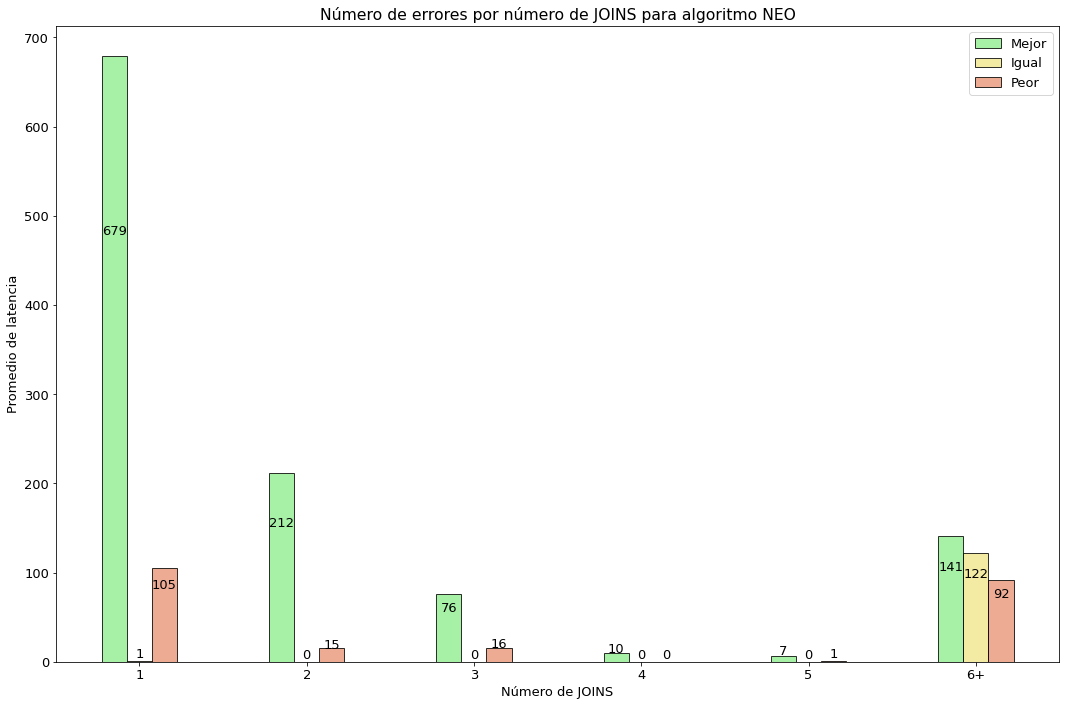

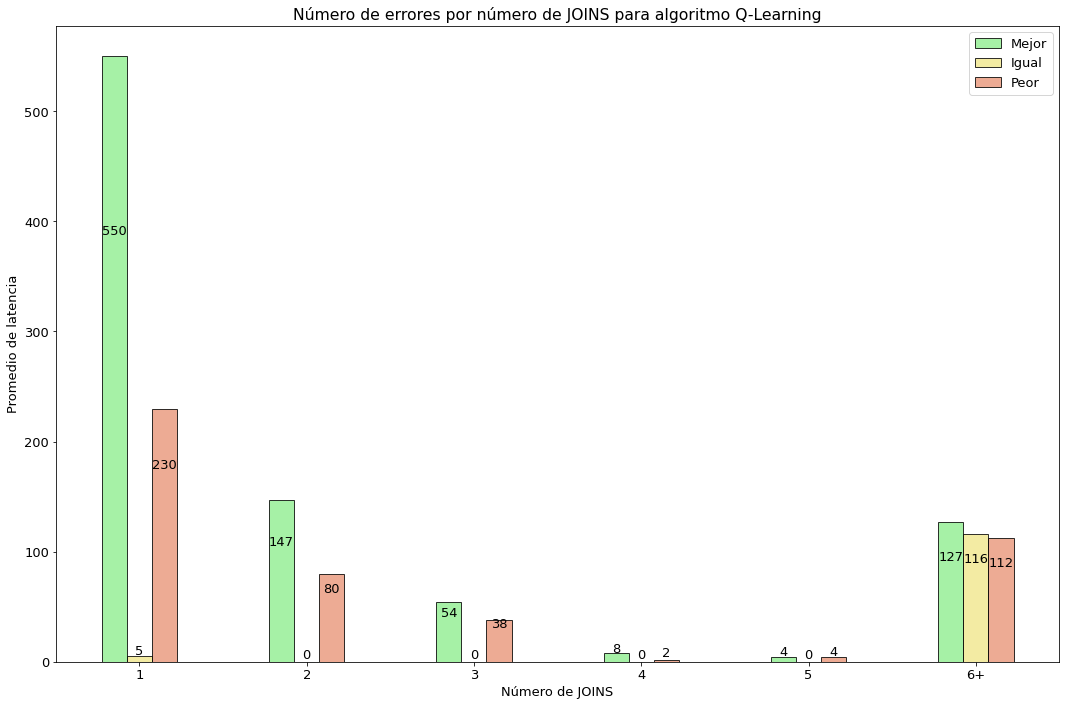

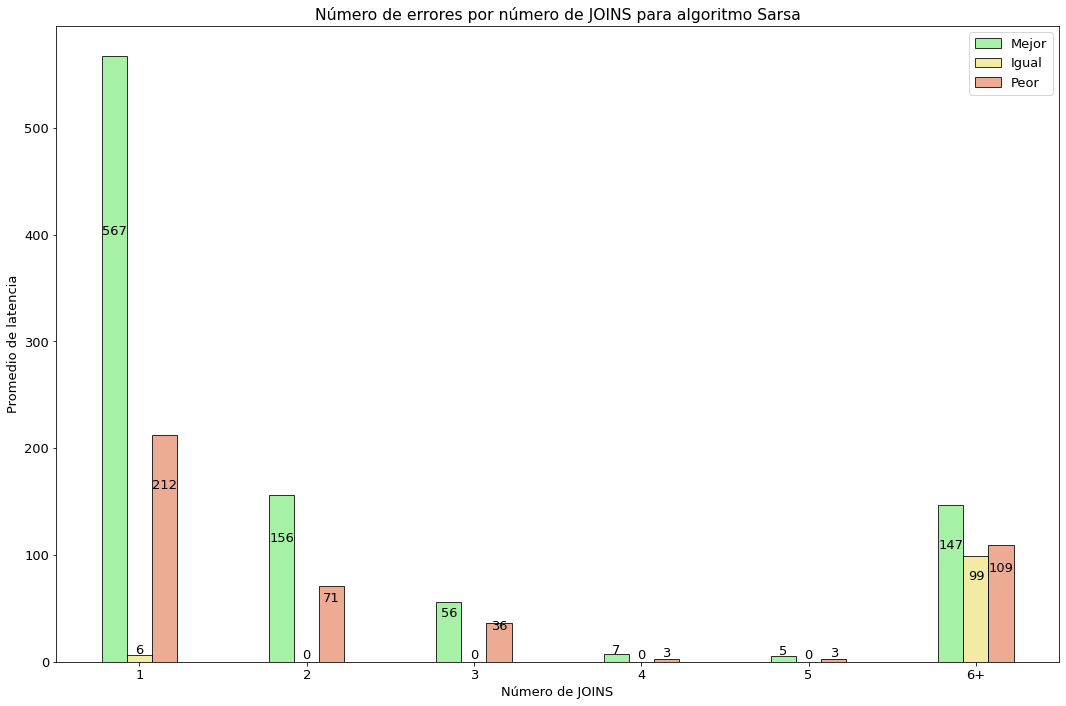

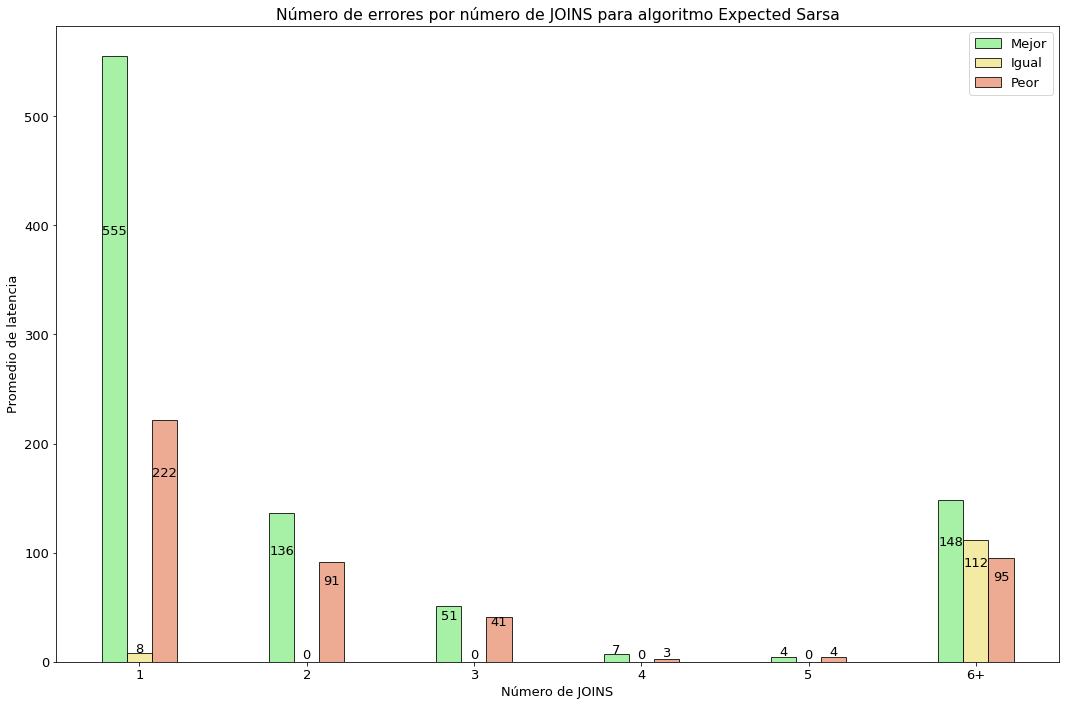

In [28]:
plot_errores_join(neo_e_joins,'NEO')
plot_errores_join(ql_e_joins,'Q-Learning')
plot_errores_join(sarsa_e_joins,'Sarsa')
plot_errores_join(exsarsa_e_joins,'Expected Sarsa')

### RMSE y MAE Por iteración

In [29]:
#ds_rl
#neo_df_final
#ql_df_final
#sarsa_df_final
#exsarsa_df_final

In [30]:
neo_df_no_history[['mse_new','mse_old']]

,mse_new,mse_old
0,191.952450,183.742377
1,182.009067,182.009067
2,181.860468,196.028199
3,65.485758,211.757874
4,73.031663,241.879715
...,...,...
295395,2065.817347,0.041882
295396,2081.055873,0.174277
295397,2048.070020,0.756308
295398,2086.464478,0.402008
